# Adiabatic rapid passage to prepare circular rydberg states
In this document, we construct a adiabatic rapid passage map to transfer the rydberg atom to the circular rydberg state.

In [1]:
# Import the relevant packages
import numpy as np
import matplotlib.pyplot as plt
from arc import *
import scipy.constants as cts
from numpy.linalg import eig


In [2]:
# Some experimental parameters and constants
# Physical constants
a_0 = cts.physical_constants['Bohr radius'][0]  # Bohr radius in meters
e = cts.e  # Electron charge in Coulombs  
hbar = cts.hbar  # Planck's constant divided by 2*pi in J*s 
h = cts.h  # Planck's constant in J*s
epsilon = cts.epsilon_0  # Vacuum permittivity in Farads/meter
c = cts.c  # Speed of light in meters/second

## Calculate the dc stark energy shift

In [3]:
'''

# Stark Map Caclulator
# ====================
# Initialise a Stark-shift Solver for Caesium
calc = StarkMap(Rubidium())

# Target state
n0 = 35
l0 = 34
j0 = 34.5
mj0 = 5.5
# Define max/min n values in basis
nmax = n0+10
nmin = n0-10
# Maximum value of l to include (l~20 gives good convergence for states with l<5)
lmax = 34

# Initialise Basis States for Solver : progressOutput=True gives verbose output
calc.defineBasis(n0, l0, j0, mj0, nmin, nmax, lmax, progressOutput=True)

Emin = 0.0  # Min E field (V/m)
Emax = 500  # Max E field (V/m)
N = 200 # Number of Points

# Generate Stark Map
calc.diagonalise(np.linspace(Emin, Emax, N), progressOutput=True)
# Show Sark Map
calc.plotLevelDiagram(progressOutput=True, units=1, highlightState=True)
calc.showPlot(interactive=False)
'''

'\n\n# Stark Map Caclulator\n# ====================\n# Initialise a Stark-shift Solver for Caesium\ncalc = StarkMap(Rubidium())\n\n# Target state\nn0 = 35\nl0 = 34\nj0 = 34.5\nmj0 = 5.5\n# Define max/min n values in basis\nnmax = n0+10\nnmin = n0-10\n# Maximum value of l to include (l~20 gives good convergence for states with l<5)\nlmax = 34\n\n# Initialise Basis States for Solver : progressOutput=True gives verbose output\ncalc.defineBasis(n0, l0, j0, mj0, nmin, nmax, lmax, progressOutput=True)\n\nEmin = 0.0  # Min E field (V/m)\nEmax = 500  # Max E field (V/m)\nN = 200 # Number of Points\n\n# Generate Stark Map\ncalc.diagonalise(np.linspace(Emin, Emax, N), progressOutput=True)\n# Show Sark Map\ncalc.plotLevelDiagram(progressOutput=True, units=1, highlightState=True)\ncalc.showPlot(interactive=False)\n'

In [4]:
# Define the function that can help us find the DC Stark shift
def find_DC_stark_shift(atom, n0, l0, j0, mj0, E_range):
    
    nmin = n0-5
    nmax = n0+5
    lmax = n0 - 1
    calc_dc = StarkMap(atom)
    # define basis for dc stark shift
    calc_dc.defineBasis(n0, l0, j0, mj0, nmin, nmax, lmax, progressOutput=False)
    # diagonalise the matrix
    calc_dc.diagonalise(E_range, progressOutput=False)

    energyOfOriginalState = (
    atom.getEnergy(n0, l0, j0) * e / h * 1e-9)  # in GHz
        
    calc_dc_shifts = (
        energyOfOriginalState- np.asarray(calc_dc.y)
    ) 
    # Track the minimum values of the energy
    targetEigInd = np.argmin(np.abs(calc_dc_shifts[0]))
    calc_dc_targetShifts = calc_dc_shifts[:, targetEigInd]

    return calc_dc_targetShifts




In [ ]:
atom = Rubidium()
n0 = 20
l0 = n0-1
j0 = l0+0.5
E_range = np.linspace(0, 500, 200) #in V/m
energy_shifts = []
for mj0 in np.arange(0.5, j0, 1):
    energy_shift = find_DC_stark_shift(atom, n0, l0, j0, mj0, E_range)
    energy_shifts.append(energy_shift)



In [45]:
filename = 'data/ARP20n.npz'
np.savez(filename, E_range, energy_shifts, 
            E_range = E_range, energy_shifts = energy_shifts)

In [46]:
# load the data
file_name = 'data/ARP20n.npz'
E_range = np.load(file_name)['E_range']
energy_shifts = np.load(file_name)['energy_shifts']

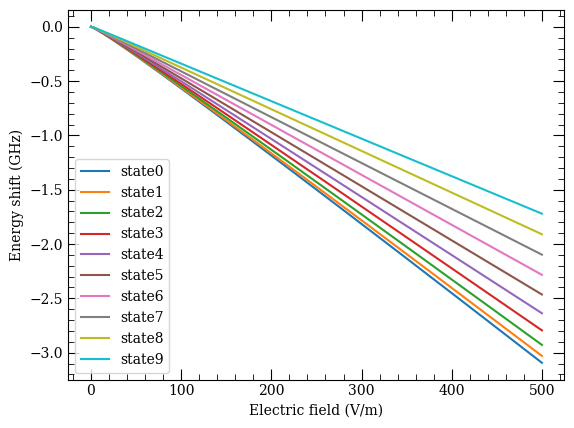

In [47]:
for n in range(10):
    plt.plot(E_range,energy_shifts[n],label = 'state'+str(n))
plt.xlabel('Electric field (V/m)')
plt.ylabel('Energy shift (GHz)')
plt.legend()
plt.show()

## Calculate the rabi frequency between the two states


In [48]:
from scipy.sparse import csr_matrix
from scipy.linalg import eigh
import sys
import numpy as np
from numpy.linalg import eig


class MatrixElementsEfield:
    def __init__(self, StarkMap1, StarkMap2, progressOutput=False):
        """
        calculates dipolar coupling between the two original target states
        of the two Stark Maps

        Note:
            StarkMaps have to have **defined basis**
            AND
            StarkMaps have to be calculated **for the same atom**
        """
        # save pointers to Stark maps for later
        self.StarkMap1 = StarkMap1
        self.StarkMap2 = StarkMap2
        # construct and save CSV sparce matrix of couplings
        matrixDMEcoupling = [[], [], []]

        for i in range(len(StarkMap1.basisStates)):
            if progressOutput:
                sys.stdout.write(
                    "\r%d%%"
                    % (float(i) / float(len(StarkMap1.basisStates) - 1) * 100)
                )
                sys.stdout.flush()
            for j in range(len(StarkMap2.basisStates)):
                # if dipole coupled, add to coupling
                dl = abs(
                    StarkMap1.basisStates[i][1] - StarkMap2.basisStates[j][1]
                )
                dj = abs(
                    StarkMap1.basisStates[i][2] - StarkMap2.basisStates[j][2]
                )
                if dl == 1 and (dj < 1.1):
                    dme = StarkMap1.atom.getDipoleMatrixElement(
                        StarkMap1.basisStates[i][0],
                        StarkMap1.basisStates[i][1],
                        StarkMap1.basisStates[i][2],
                        StarkMap1.basisStates[i][3],
                        StarkMap2.basisStates[j][0],
                        StarkMap2.basisStates[j][1],
                        StarkMap2.basisStates[j][2],
                        StarkMap2.basisStates[j][3],
                        q,
                    )
                    matrixDMEcoupling[0].append(dme)
                    matrixDMEcoupling[1].append(i)
                    matrixDMEcoupling[2].append(j)

        self.matrixDMEcoupling = csr_matrix(
            (
                matrixDMEcoupling[0],
                (matrixDMEcoupling[1], matrixDMEcoupling[2]),
            ),
            shape=(len(StarkMap1.basisStates), len(StarkMap2.basisStates)),
        )

    def getDipolarCoupling(self, eFields,n0,l0,j0):
        """
        find dipolar coupling and transition frequency between target states for a range of electric fields

        Target states are specified during the initialization procedure of the StarkMap1 and StarkMap2
        """
        self.y1 = []
        self.y2 = []
        couplings = []
        energy_diffs = []   
        energy1s = []
        energy2s = []
        
        '''
        m1 = self.StarkMap1.mat1 + self.StarkMap1.mat2 * eField
        ev1, egvector1 = eigh(m1)        
            # find first state in electric field
        sorted_indices1 = np.argsort(ev1)
        sorted_ev1 = ev1[sorted_indices1]
        sorted_egvector1 = egvector1[:, sorted_indices1]
        
        
        m2 = self.StarkMap2.mat1 + self.StarkMap2.mat2 * eField
        ev2, egvector2 = eigh(m2)
        # find second state in electric field
        sorted_indices2 = np.argsort(ev2)
        sorted_ev2 = ev2[sorted_indices2]
        sorted_egvector2 = egvector2[:, sorted_indices2]
        i=0
        if i<5:
            # locate which of the eigenvectors has biggest contribution of the orginal state
            state1index = np.argmax(
                np.absolute(sorted_egvector1[self.StarkMap1.indexOfCoupledState, :])
            )

            state2index = np.argmax(
                np.absolute(sorted_egvector2[self.StarkMap2.indexOfCoupledState, :])
            )

        state1composition = sorted_egvector1[:, state1index]
        energy1 = sorted_ev1[state1index]
        state2composition = sorted_egvector2[:, state2index]
        energy2 = sorted_ev2[state2index]
        coupling = self.matrixDMEcoupling.dot(state2composition).dot(
            state1composition
        )

        couplings.append(np.abs(coupling))
        energy_diffs.append(np.abs(energy1 - energy2))
        energy1s.append(energy1)
        energy2s.append(energy2)
        i+=1
        '''
        '''
        m1 = self.StarkMap1.mat1 + self.StarkMap1.mat2 * eField
        ev1, egvector1 = eigh(m1)
        # find second state in electric field
        m2 = self.StarkMap2.mat1 + self.StarkMap2.mat2 * eField
        ev2, egvector2 = eigh(m2)
        '''
        self.StarkMap1.diagonalise(eFields, progressOutput=False)
        self.StarkMap2.diagonalise(eFields, progressOutput=False)

        # locate which of the eigenvectors has biggest contribution of the orginal state
        # and save that state composition
        # NOTE: advanced users might want to change this close to avoided crossings
        
        #-----------------find the index of the target state-----------------
        
    
        atom = Rubidium()
        
        energyOfOriginalState = (
        
        atom.getEnergy(n0, l0, j0) * e / h * 1e-9)  # in GHz
        
        calc_dc_shifts1 = (
            energyOfOriginalState- np.asarray(self.StarkMap1.y)
        ) 
        # Track the minimum values of the energy
        targetEigInd1 = np.argmin(np.abs(calc_dc_shifts1[0]))
        energy1s = calc_dc_shifts1[:, targetEigInd1]
        ei1 = np.array(self.StarkMap1.ei)
        state1compositions = ei1[:,:,targetEigInd1]

        calc_dc_shifts2 = (
            energyOfOriginalState- np.asarray(self.StarkMap2.y)
        )
        targetEigInd2 = np.argmin(np.abs(calc_dc_shifts2[0]))
        energy2s = calc_dc_shifts2[:, targetEigInd2]
        ei2 = np.array(self.StarkMap2.ei)
        state2compositions = ei2[:,:,targetEigInd2]
        couplings = []
        energy_diffs = np.abs(energy1s - energy2s)
        for j in range(len(eFields)):

            coupling = self.matrixDMEcoupling.dot(state2compositions[j]).dot(
                state1compositions[j]
            )

            couplings.append(np.abs(coupling))
        '''
        state1index = np.argmax(
            np.absolute(egvector1[self.StarkMap1.indexOfCoupledState, :])
                )

        state2index = np.argmax(
            np.absolute(egvector2[self.StarkMap2.indexOfCoupledState, :])
                )
        '''
        '''
        state1composition = egvector1[:, state1index]
        energy1 = ev1[state1index]
        
        #-----------------find the index of the target state-----------------



        # locate which of the eigenvectors has biggest contribution of the orginal state, and save that state composition

        state2composition = egvector2[:, state2index]
        energy2 = ev2[state2index]

        # find coupling between the states

        coupling = self.matrixDMEcoupling.dot(state2composition).dot(
            state1composition
        )

        couplings.append(np.abs(coupling))
        energy_diffs.append(np.abs(energy1 - energy2))
        energy1s.append(energy1)
        energy2s.append(energy2)
        i+=1
        '''
        return couplings, energy_diffs, energy1s, energy2s
        

In [38]:
# Plot the dipole matrix elements vs deltaN
atom = Rubidium()
n0 = 20
l0 = n0-1
j0 = l0+0.5
mj01 = 0.5
mj02 = 1.5
q=1
deltaN = 5
maxL = n0-1


stMap1 = StarkMap(atom)
stMap1.defineBasis(
    n0, l0, j0, mj01, n0 - deltaN, n0 + deltaN, maxL, progressOutput=False
)

stMap2 = StarkMap(atom)
stMap2.defineBasis(
    n0, l0, j0, mj02, n0 - deltaN, n0 + deltaN, maxL, progressOutput=False
)




0

In [25]:
calc = MatrixElementsEfield(stMap1, stMap2, progressOutput=False)
eFields = np.linspace(0, 500, 200)


In [26]:
c, f, e1, e2 = calc.getDipolarCoupling(eFields,n0,l0,j0)

In [30]:
energyOfOriginalState = (
    atom.getEnergy(n0, l0, j0) * e / h * 1e-9
)  # in GHz
energysOfOriginalState = []
for eField in eFields:
    energysOfOriginalState.append(energyOfOriginalState)

print(energyOfOriginalState)

-8224.553122836323


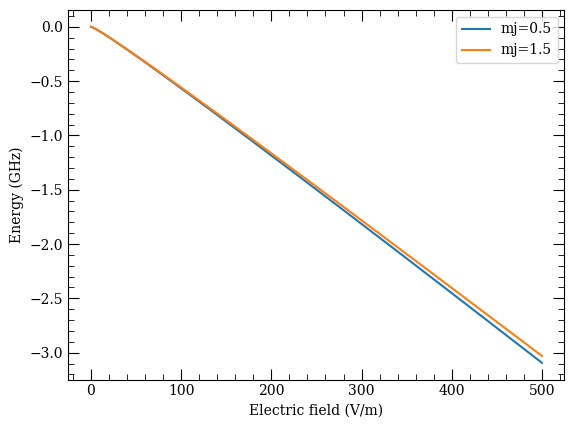

In [31]:
plt.plot(eFields, e1, label='mj=0.5')
plt.plot(eFields, e2, label='mj=1.5')
#plt.plot(eFields, energysOfOriginalState, label='original state')
plt.xlabel('Electric field (V/m)')
plt.ylabel('Energy (GHz)')
plt.legend()
plt.show()

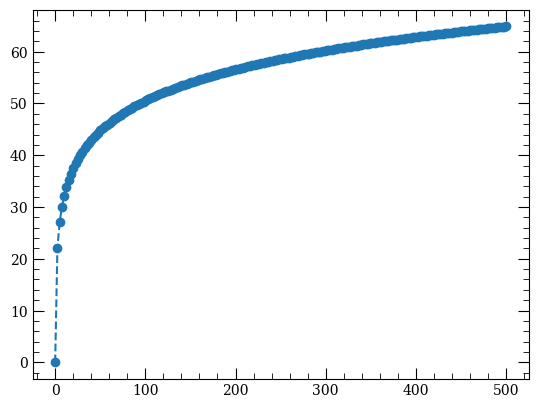

In [32]:
plt.plot(eFields, c, 'o--')

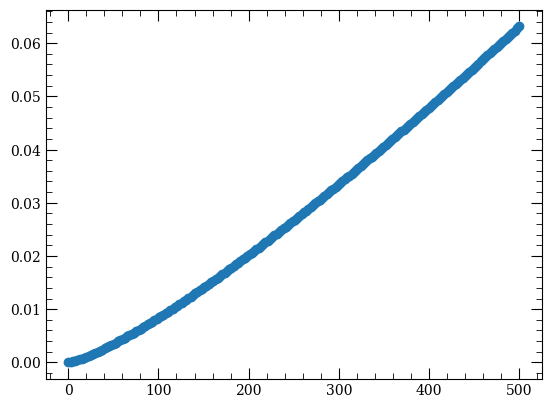

In [33]:
plt.plot(eFields, f, 'o--')

In [ ]:
# Plot the dipole matrix elements vs deltaN
'''
atom = Rubidium()
q=1
maxL = 34
cs=[]
deltaNs = range(1,21)
for deltaN in deltaNs:  

    stMap1 = StarkMap(atom)
    stMap1.defineBasis(
        35, 34, 34.5, 0.5, 35 - deltaN, 35 + deltaN, maxL, progressOutput=False
    )

    stMap2 = StarkMap(atom)
    stMap2.defineBasis(
        35, 34, 34.5, 1.5, 35 - deltaN, 35 + deltaN, maxL, progressOutput=False
    )

    calc = MatrixElementsEfield(stMap1, stMap2, progressOutput=False)
    c, f = calc.getDipolarCoupling(500)
    cs.append(c)
    '''


In [46]:

np.savez('data/dme_deltaNs.npz', deltaNs, cs, 
            deltaNs = deltaNs, cs = cs)

In [8]:
file_name = 'data/dme_deltaNs.npz'
deltaNs = np.load(file_name)['deltaNs']
cs = np.load(file_name)['cs']

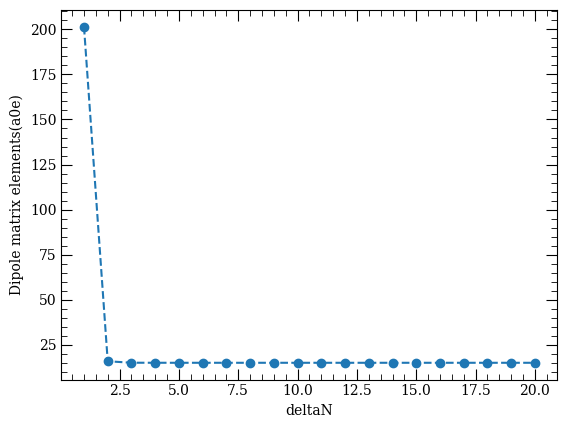

In [9]:
plt.plot(deltaNs, cs,"o--")
plt.xlabel('deltaN')
plt.ylabel('Dipole matrix elements(a0e)')
plt.show()

In [50]:
# Calculate the dipole matrix elements between different states

atom = Rubidium()
n0 = 20 # principal quantum number
l0 = n0-1 # orbital angular momentum
j0 = l0+0.5 # total angular momentum
deltaN = 5 # deltaN
maxL = n0-1 # maximum value of l to include
q=1 # sigma+ transition
mj0s = np.arange(0.5, j0, 1)
dipole_matrix_elements = []
energy_shifts2 = []

for mj0 in mj0s:
    stMap1 = StarkMap(atom)
    stMap1.defineBasis(
        n0, l0, j0, mj0, n0 - deltaN, n0 + deltaN, maxL, progressOutput=False
    )
    stMap2 = StarkMap(atom)
    stMap2.defineBasis(
        n0, l0, j0, mj0+1, n0 - deltaN, n0 + deltaN, maxL, progressOutput=False
    )


    calc = MatrixElementsEfield(stMap1, stMap2, progressOutput=False)

    couplingList, frequencyList,energy1s, energy2s = calc.getDipolarCoupling(E_range,n0,l0,j0)
    dipole_matrix_elements.append(couplingList)
    energy_shifts2.append(frequencyList)

dipole_matrix_elements = np.array(dipole_matrix_elements)
energy_shifts2 = np.array(energy_shifts2)



In [88]:

E_range.shape
dipole_matrix_elements.shape

AttributeError: 'list' object has no attribute 'shape'

In [52]:
np.savez('data/dmes.npz', mj0s, dipole_matrix_elements, energy_shifts2,
            mj0s = mj0s, dipole_matrix_elements = dipole_matrix_elements, energy_shifts2 = energy_shifts2)

In [53]:
file_name = 'data/dmes.npz'
mj0s = np.load(file_name)['mj0s']
dipole_matrix_elements = np.load(file_name)['dipole_matrix_elements']
energy_shifts2 = np.load(file_name)['energy_shifts2']


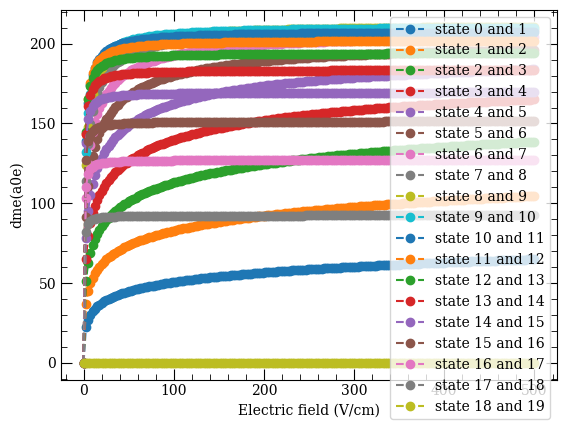

In [58]:
for n in range(19):
    plt.plot(E_range,dipole_matrix_elements[n],"o--",label = f'state {n} and {n+1}')
plt.xlabel('Electric field (V/cm)')
plt.ylabel('dme(a0e)')
plt.legend()
plt.show()

In [99]:
# Calculate the Rabi frequency
E0 = 10
rabi_frequencies = E0*dipole_matrix_elements/hbar*a_0*e/(1e9)

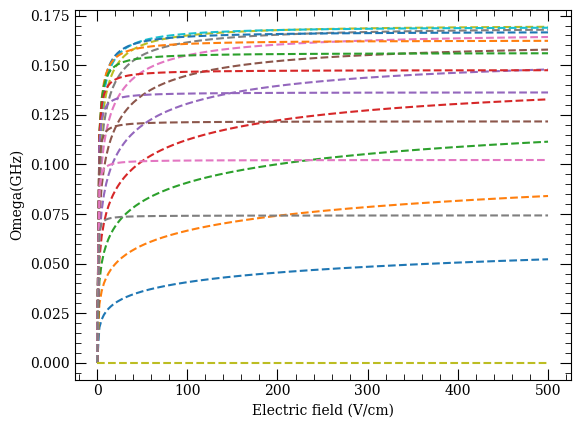

In [100]:
for n in range(19):
    plt.plot(E_range,rabi_frequencies[n],"--",label = f'state {n} and {n+1}')
plt.xlabel('Electric field (V/cm)')
plt.ylabel('Omega(GHz)')
#plt.legend()
plt.show()

## Create a matrix of the Hamiltonian in the basis of the |n,l,mj> states

In [101]:
atom = Rubidium()
di = 19

# The electric field at resonance in V/cm
laser_energy = np.interp(3, E_range, energy_shifts[1])-\
np.interp(3, E_range, energy_shifts[0])

hamiltonian_matrix = np.zeros((di,di),dtype = complex)
energys = [[] for i in range(di)]
    
# Diagonal elements are energy shifts

for m in range(len(E_range)):

    diagonals = [(energy_shifts[n][m]-energy_shifts[0][m]-laser_energy) for n in range(di)]
    for i in range(di):
        hamiltonian_matrix[i,i] = diagonals[i]
        hamiltonian_matrix[0,0] = 0
    
        if i < di-1:
            hamiltonian_matrix[i,i+1] = hamiltonian_matrix[i+1,i] = 0.5*rabi_frequencies[i][m]
            #hamiltonian_matrix[i,i+1] = hamiltonian_matrix[i+1,i] = 0
            

    
        w, v = eig(hamiltonian_matrix)
        w_sorted_indices = np.argsort(w)
        energys[i].append(w[w_sorted_indices[i]])





    

In [87]:

np.savez('data/no_interaction10.npz', E_range, energys, 
            E_range = E_range, energys = energys)

In [88]:
# load the data
file_name = 'data/no_interaction10.npz'
Efields0 = np.load(file_name)['E_range']
energys0 = np.load(file_name)['energys']

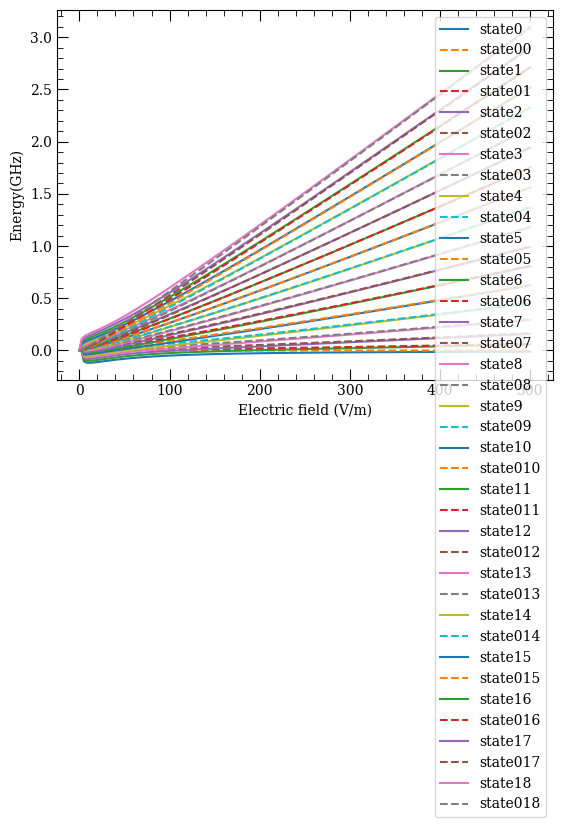

In [102]:
fig=plt.figure()
ax = fig.add_subplot(111)
for n in range(19):
    plt.plot(E_range,energys[n],label = 'state'+str(n))
    plt.plot(E_range,energys0[n],"--",label = 'state0'+str(n))

plt.xlabel('Electric field (V/m)')
plt.ylabel('Energy(GHz)')
plt.legend()
plt.show()